<a href="https://colab.research.google.com/github/dmitr2ish/MOMO_2023/blob/main/ishmitov_momo_2023_practice_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Математические основы машинного обучения
## Практическое задание №1

Import библиотек

In [184]:
import pandas as pd # для работы с табличными данными
import numpy as np # для операций линейной алгебры и прочего
import matplotlib.pyplot as plt # для визуализации данных
import seaborn as sns # для визуализации данных из Pandas
from google.colab import userdata

# предварительная обработка числовых признаков
from sklearn.preprocessing import MinMaxScaler # нормализация
from sklearn.preprocessing import StandardScaler # стандартизация
from sklearn.preprocessing import PowerTransformer  # степенное преобразование

# предварительная обработка категориальных признаков
from sklearn.preprocessing import OneHotEncoder # One-Hot Encoding
from sklearn.preprocessing import OrdinalEncoder # порядковое кодирование

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer # преобразователь колонок
from sklearn.base import BaseEstimator, TransformerMixin # для создания собственных преобразователей/трансформеров данных

from google.colab import files # для загрузки набора данных


plt.style.use('dark_background') # для модных черных рисунков

## Постановка цели

В данной практической работе я решил попробовать поработать с дата сетом крипто валюты [Bitcoin](https://www.kaggle.com/datasets/sudalairajkumar/cryptocurrencypricehistory?select=coin_Cardano.csv) за период c 2013 по 2021

В качестве задачи мы попробуем построить графики цен, найти зависимости между признаками изменения стоимости валюты к закрытию для криптовалюты bitcoin

## Разведка

### Подготовка

Загружаем дата фрейм

In [185]:
DF = pd.read_csv("/content/coin_Bitcoin.csv")

Посмотрим содержимое дата фрейма

In [186]:
DF

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Bitcoin,BTC,2013-04-29 23:59:59,147.488007,134.000000,134.444000,144.539993,0.000000e+00,1.603769e+09
1,2,Bitcoin,BTC,2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000,0.000000e+00,1.542813e+09
2,3,Bitcoin,BTC,2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998,0.000000e+00,1.298955e+09
3,4,Bitcoin,BTC,2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999,0.000000e+00,1.168517e+09
4,5,Bitcoin,BTC,2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000,0.000000e+00,1.085995e+09
...,...,...,...,...,...,...,...,...,...,...
2986,2987,Bitcoin,BTC,2021-07-02 23:59:59,33939.588699,32770.680780,33549.600177,33897.048590,3.872897e+10,6.354508e+11
2987,2988,Bitcoin,BTC,2021-07-03 23:59:59,34909.259899,33402.696536,33854.421362,34668.548402,2.438396e+10,6.499397e+11
2988,2989,Bitcoin,BTC,2021-07-04 23:59:59,35937.567147,34396.477458,34665.564866,35287.779766,2.492431e+10,6.615748e+11
2989,2990,Bitcoin,BTC,2021-07-05 23:59:59,35284.344430,33213.661034,35284.344430,33746.002456,2.672155e+10,6.326962e+11


Количество обьектов и признаков подходит в рамках практического задания, проверим типы данных

In [187]:
DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2991 entries, 0 to 2990
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SNo        2991 non-null   int64  
 1   Name       2991 non-null   object 
 2   Symbol     2991 non-null   object 
 3   Date       2991 non-null   object 
 4   High       2991 non-null   float64
 5   Low        2991 non-null   float64
 6   Open       2991 non-null   float64
 7   Close      2991 non-null   float64
 8   Volume     2991 non-null   float64
 9   Marketcap  2991 non-null   float64
dtypes: float64(6), int64(1), object(3)
memory usage: 233.8+ KB


 Хорошие новости что нет null значений,  плохие, что дата не приведена к верному типу.

 Выполним предподогтовку данных, проверим на пустые значения и преобразуем тип Date к datetime типу, а SNo к строковому типу, чтобы он не мешался нам в будущем в числовых типах

In [188]:
# id конвертируем чтобы он не попадал в числовые типы данных
DF['SNo'] = DF['SNo'].astype(str)

# Конвертируем 'Date' в datetime тип
DF['Date'] = pd.to_datetime(DF['Date'])

# Еще раз проверим на null
null_values = DF.isnull().sum()

# Проверим на нулевые или отрицательные значения
zero_marketcap = ((DF['Marketcap'] == 0) | (DF['Marketcap'] < 0)).sum()
zero_volume = ((DF['Volume'] == 0) | (DF['Volume'] < 0)).sum()
zero_open = ((DF['Open'] == 0) | (DF['Open'] < 0)).sum()
zero_close = ((DF['Close'] == 0) | (DF['Close'] < 0)).sum()

print(null_values)

print("количество записей с нулевым обьемом рынка {}".format(zero_marketcap))
print("количество записей с нулевым обьемом {}".format(zero_volume))
print("количество записей с нулевой ценой открытия {}".format(zero_open))
print("количество записей с нулевой ценой закрытия {}".format(zero_close))
print("количество дупликатов {}".format(DF.duplicated().sum()))

SNo          0
Name         0
Symbol       0
Date         0
High         0
Low          0
Open         0
Close        0
Volume       0
Marketcap    0
dtype: int64
количество записей с нулевым обьемом рынка 0
количество записей с нулевым обьемом 242
количество записей с нулевой ценой открытия 0
количество записей с нулевой ценой закрытия 0
количество дупликатов 0


Мы нашли 242 записи с нулевым обьемом посмотрим что это за записи

In [189]:
DF[(DF['Volume'] == 0)]

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Bitcoin,BTC,2013-04-29 23:59:59,147.488007,134.000000,134.444000,144.539993,0.0,1.603769e+09
1,2,Bitcoin,BTC,2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000,0.0,1.542813e+09
2,3,Bitcoin,BTC,2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998,0.0,1.298955e+09
3,4,Bitcoin,BTC,2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999,0.0,1.168517e+09
4,5,Bitcoin,BTC,2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000,0.0,1.085995e+09
...,...,...,...,...,...,...,...,...,...,...
237,238,Bitcoin,BTC,2013-12-22 23:59:59,666.739990,585.640015,601.780029,617.179993,0.0,7.505757e+09
238,239,Bitcoin,BTC,2013-12-23 23:59:59,680.909973,611.039978,613.059998,673.409973,0.0,8.192487e+09
239,240,Bitcoin,BTC,2013-12-24 23:59:59,684.390015,645.710022,672.359985,665.580017,0.0,8.100042e+09
240,241,Bitcoin,BTC,2013-12-25 23:59:59,682.700012,649.479980,666.309998,682.210022,0.0,8.305173e+09


Отсутствующее данное значение определенно ошибка, поскольку этих записей небольшое количество мы можем безболезненно их удалить и сбросить индексы

In [190]:
DF = DF.drop(DF[DF['Volume'] == 0].index)

print("количество записей с нулевым обьемом {}".format((DF['Volume'] == 0).sum()))

DF = DF.reset_index(drop=True)

DF.tail(5)

количество записей с нулевым обьемом 0


,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
2744,2987,Bitcoin,BTC,2021-07-02 23:59:59,33939.588699,32770.680780,33549.600177,33897.048590,3.872897e+10,6.354508e+11
2745,2988,Bitcoin,BTC,2021-07-03 23:59:59,34909.259899,33402.696536,33854.421362,34668.548402,2.438396e+10,6.499397e+11
2746,2989,Bitcoin,BTC,2021-07-04 23:59:59,35937.567147,34396.477458,34665.564866,35287.779766,2.492431e+10,6.615748e+11
2747,2990,Bitcoin,BTC,2021-07-05 23:59:59,35284.344430,33213.661034,35284.344430,33746.002456,2.672155e+10,6.326962e+11
2748,2991,Bitcoin,BTC,2021-07-06 23:59:59,35038.536363,33599.916169,33723.509655,34235.193451,2.650126e+10,6.418992e+11


In [191]:
DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2749 entries, 0 to 2748
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   SNo        2749 non-null   object        
 1   Name       2749 non-null   object        
 2   Symbol     2749 non-null   object        
 3   Date       2749 non-null   datetime64[ns]
 4   High       2749 non-null   float64       
 5   Low        2749 non-null   float64       
 6   Open       2749 non-null   float64       
 7   Close      2749 non-null   float64       
 8   Volume     2749 non-null   float64       
 9   Marketcap  2749 non-null   float64       
dtypes: datetime64[ns](1), float64(6), object(3)
memory usage: 214.9+ KB


Поскольку мы работаем только с одной криптовалютой в рамках данного практического задания, мы работаем только с числовыми признаками:
- Date - время закрытия
- High - макс цена
- Low - мин цена
- Open - цена при открытии
- Close - цена при закрытии
- Volume - обьем торгов
- Marketcap - рыночная капитализация

Однако можно добавить один категориальный признак:
- Price_Change - валюта подешевела, подорожала или осталась без изменений

Давайте добавим его

In [193]:
# Добавляем новый столбец 'Price_Change'
# Используем np.where из библиотеки NumPy для векторизованного условного выражения


DF['Price_Change'] = np.where(DF['Close'] > DF['Open'], 1,
                              np.where(DF['Close'] < DF['Open'], -1, 0))

# Теперь DF['Price_Change'] будет содержать 1 для подорожания, -1 для удешевления и 0 без изменения

DF
DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2749 entries, 0 to 2748
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   SNo           2749 non-null   object        
 1   Name          2749 non-null   object        
 2   Symbol        2749 non-null   object        
 3   Date          2749 non-null   datetime64[ns]
 4   High          2749 non-null   float64       
 5   Low           2749 non-null   float64       
 6   Open          2749 non-null   float64       
 7   Close         2749 non-null   float64       
 8   Volume        2749 non-null   float64       
 9   Marketcap     2749 non-null   float64       
 10  Price_Change  2749 non-null   int64         
dtypes: datetime64[ns](1), float64(6), int64(1), object(3)
memory usage: 236.4+ KB


В целом разведка прошла успешно, переходим к анализу данных

## Анализ данных

подготовим наши  числовые признаки и посмотрим статистику по числовым признакам

In [196]:
num_columns = []

for column_name in DF.columns: # смотрим на все колонки в DataFrame
    if (DF[column_name].dtypes == np.float64): # проверяем тип данных для каждой колонки
        num_columns +=[column_name] # если тип объект - то складываем в категориальные данные

DF.describe()

,High,Low,Open,Close,Volume,Marketcap,Price_Change
count,2749.000000,2749.000000,2749.000000,2749.000000,2.749000e+03,2.749000e+03,2749.000000
mean,7477.294496,7036.727796,7268.361953,7280.272226,1.186644e+10,1.312580e+11,0.067297
std,11969.528338,11170.691310,11603.570695,11613.792111,1.941175e+10,2.169846e+11,0.997914
min,211.731003,171.509995,176.897003,178.102997,2.857830e+06,2.444379e+09,-1.000000
25%,508.220001,482.951996,495.454987,495.665985,4.872260e+07,6.944861e+09,-1.000000
50%,3743.387971,3619.182130,3671.369989,3671.203705,2.219410e+09,6.406376e+10,1.000000
75%,9164.362260,8727.089844,8912.524340,8909.953651,1.757206e+10,1.589499e+11,1.000000
max,64863.098908,62208.964366,63523.754869,63503.457930,3.509679e+11,1.186364e+12,1.000000


Сгруппируем по дате

In [197]:
grouped = DF.groupby('Date').mean(num_columns)
grouped

,High,Low,Open,Close,Volume,Marketcap,Price_Change
Date,,,,,,,
2013-12-27 23:59:59,777.510010,713.599976,763.280029,735.070007,4.686270e+07,8.955395e+09,-1.0
2013-12-28 23:59:59,747.059998,705.349976,737.979980,727.830017,3.250580e+07,8.869919e+09,-1.0
2013-12-29 23:59:59,748.609985,714.440002,728.049988,745.049988,1.901130e+07,9.082104e+09,1.0
2013-12-30 23:59:59,766.599976,740.239990,741.349976,756.130005,2.070770e+07,9.217168e+09,1.0
2013-12-31 23:59:59,760.580017,738.169983,760.320007,754.010010,2.089730e+07,9.191325e+09,-1.0
...,...,...,...,...,...,...,...
2021-07-02 23:59:59,33939.588699,32770.680780,33549.600177,33897.048590,3.872897e+10,6.354508e+11,1.0
2021-07-03 23:59:59,34909.259899,33402.696536,33854.421362,34668.548402,2.438396e+10,6.499397e+11,1.0
2021-07-04 23:59:59,35937.567147,34396.477458,34665.564866,35287.779766,2.492431e+10,6.615748e+11,1.0


Посмотрим на корреляцию числовых признаков

In [198]:
DF[num_columns].corr().style.background_gradient(cmap = 'YlOrRd', # наш цветовой стиль
                                    vmin = -1, # указываем нижний диапазон
                                    vmax=1) # указываем верхний  диапазон

,High,Low,Open,Close,Volume,Marketcap
High,1.000000,0.998809,0.999426,0.999400,0.804832,0.999077
Low,0.998809,1.000000,0.998874,0.999270,0.797191,0.999059
Open,0.999426,0.998874,1.000000,0.998606,0.802722,0.998346
Close,0.999400,0.999270,0.998606,1.000000,0.801637,0.999712
Volume,0.804832,0.797191,0.802722,0.801637,1.000000,0.803593
Marketcap,0.999077,0.999059,0.998346,0.999712,0.803593,1.000000


### Вывод первый - высокая корреляция

Делаем несколько выводов и преположений:
- у нас высокая корреляция между High, Low, Open и Close
    - Значения корреляции близки к 1, что указывает на очень сильную положительную линейную связь между максимальными (High), минимальными (Low), открывающими (Open) и закрывающими (Close) ценами. Это ожидаемо, так как цены в течение одного торгового дня обычно движутся вместе.

- сильная корреляция Volume и Marketcap с ценами:
    - объем торгов (Volume) и рыночная капитализация (Marketcup) также показывают сильную корреляцию, но не такую высокую, как между самими ценами. Это может указывать на то, что с увеличением объема торгов и ростом рыночной капитализации, как правило, растут и цены.

## Визуализация

### Визуализация данных с использованием Seaborn

Выполним визуализацию распределения по числовым признакам

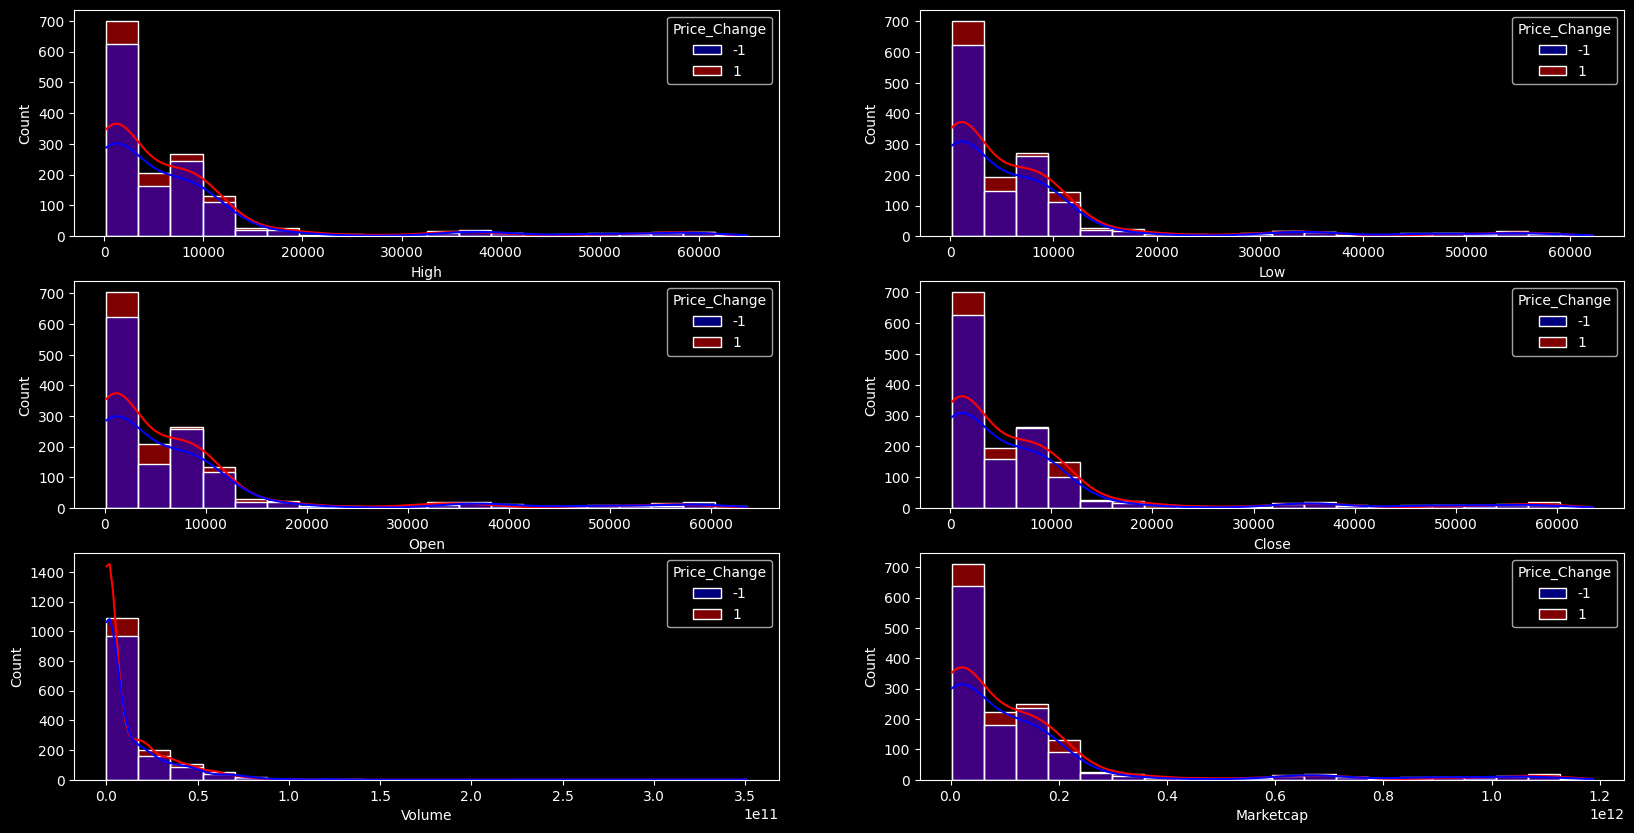

In [219]:
width = 2
height = int(np.ceil(len(num_columns)/width))
fig, ax = plt.subplots(nrows=height, ncols=width, figsize=(20,10)) # создаем "полотно", на котором будем "рисовать" графики
#     ↑  более точная структура (почти синоним subplot). Говорим что у нас будет height строк и width столбцов

for idx, column_name in enumerate(num_columns): # перебираем все числовые данные
    plt.subplot(height,width, idx+1) #берем конкретную ячейку из заранее подготовленную заготовки
    # рисуем с помощью библиотеки seaborn
    sns.histplot(data=DF, # какой датафрейм используем
                x=column_name, # какую переменную отрисовываем
                hue='Price_Change', # исп нашу категориальный признак
                kde=True, # отрисуй тренд
                palette='bwr', # цвет
                bins = 20);  # на сколько ячеек разбиваем

### Вывод второй - все нуждаются в обработке

Вывод по гистограмме, все данные нуждаются в обработке:
- Логарифмическое преобразование потребуется для столбцов с большими числами, таких как Volume и Marketcap, опять же для уменьшения влияния выбросов и **сглаживания** данных.
- Стандартизация должна быть использована для всех числовых столбцов, чтобы обеспечить единообразие масштаба.

Аналогично выполним анализ распределений с помощью библиотеки Boxplot так мы сможем визуализировать медиану, квартили и выбросы и в случае необходимости изменить план по обработке данных

Анализ распределений с помощью Boxplot

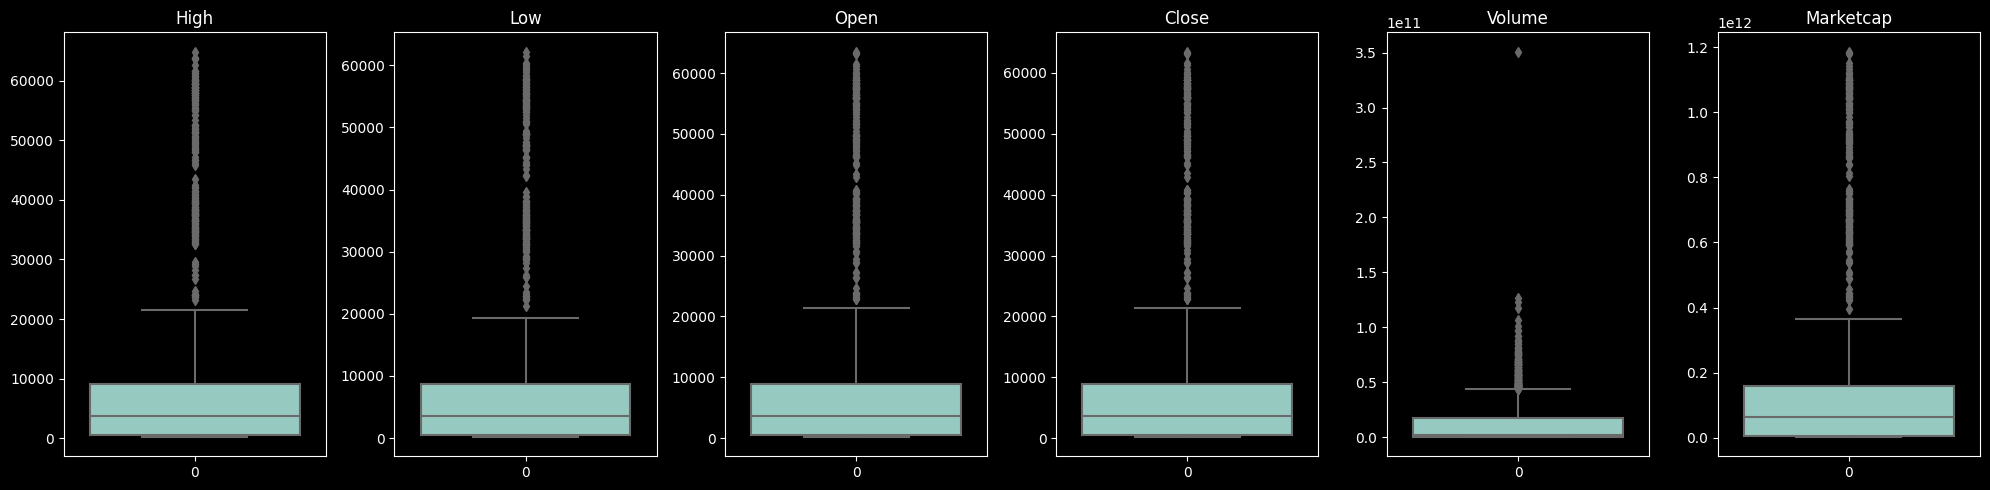

In [200]:
# Визуализация с помощью Boxplot для каждого признака
fig, axs = plt.subplots(1, 6, figsize=(20, 5))

i = 0
for column_name in num_columns:
  sns.boxplot(data=DF[column_name], ax=axs[i]).set_title(column_name)
  i += 1

plt.tight_layout()
plt.show()


### Вывод третий - смещение значительно

После проведенного анализа мы явно наблюдаем, что все признаки характеризуется значительным наличием выбросов, особенно с верхней стороны распределения, как видно из точек за пределами "усов" на boxplot. Это указывает на необходимость применения **логарифмического преобразования** для уменьшения влияния этих выбросов и нормализации распределения данных для всех признаков.

Ожидаемо после предидущей визуализации, мы обнаруживаем, что у **всех** рассматриваемых признаков центральная тенденция смещена вниз. Это свидетельствует о скошенности данных и требует применения методов нормализации, таких как центровка данных или степенное преоброзование


Визуализация отношений с помощью Pairplot

Попробуем выполнить визуализацию данных с помощью Pairplot в Seaborn чтобы оценить отношения между парами различных признаков в DataFrame. Это будет полезно для практики и подтверждения гипотез по выявлению корреляций и других интересных взаимосвязей между признаками.

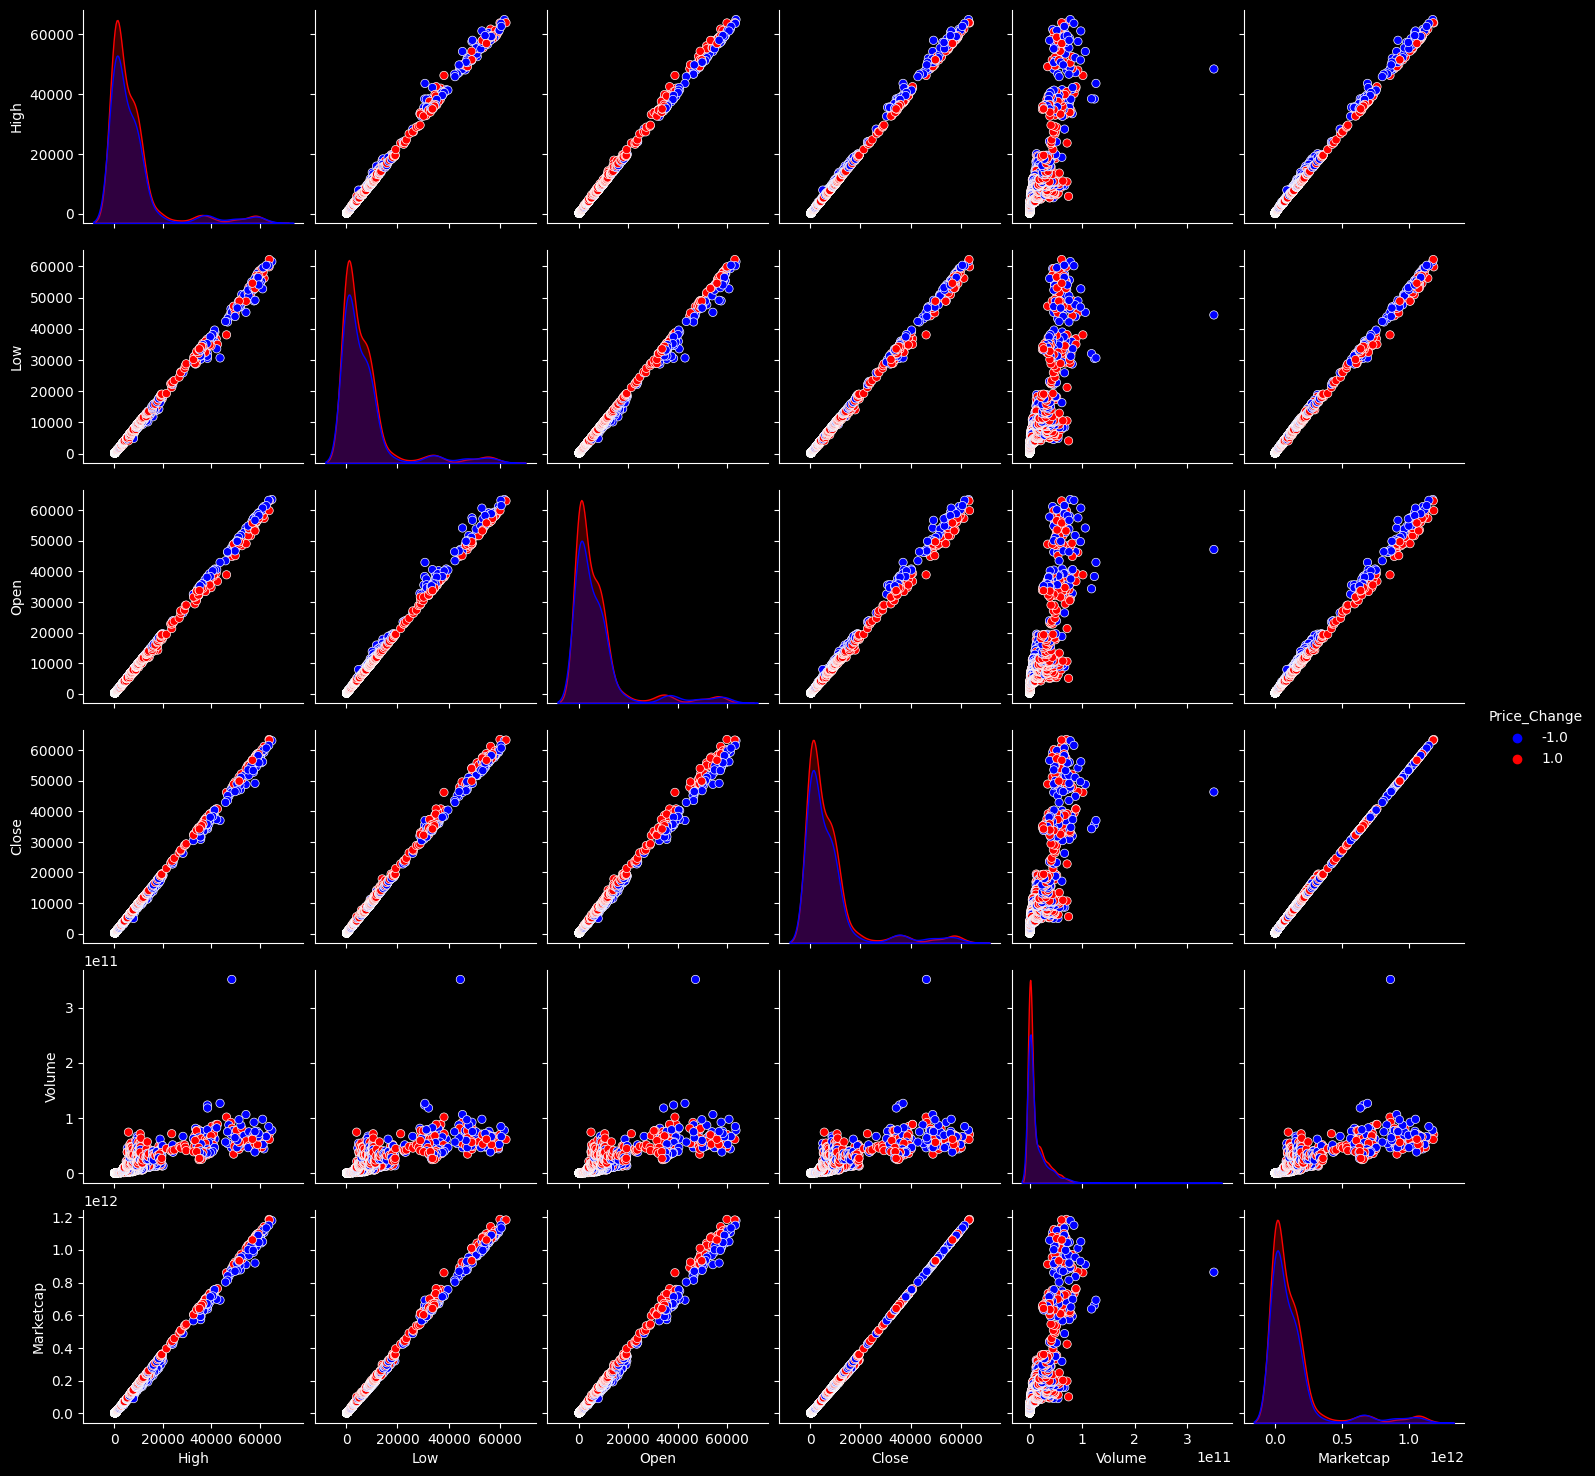

In [201]:
# Создание Pairplot для выбранных признаков
sns.pairplot(data = grouped,
              hue ='Price_Change', # какую переменную используем для подкрашиваиния данных.
                                # Рекомендуется использовать Категориальные данные (не очень много уникальных значений)
              palette = 'bwr',); # какую цветовую карту используем. Здесь у нас всего 2 варианта, то мы используем bwr - один из Diverging
                                # если категорий больше, то лучше использовать что-то из Qualitative
plt.show()

### Вывод четвертый - подтверждение гипотезы

Гипотеза подтверждается, мы видим сильную линейную зависимость между ценами. Это отличная находка в случае построении модели линейной регресси для предсказания цены по признакам.

## Общий вывод по анализу данных

- Выбросы - требуется очистка от выбросов и логарифмическое преоброзование для всех признаков
- Стандартизация - для обеспечения единообразия масштаба также для всех признаков

## Преоброзование данных

### Логарифмическое преоброзование

In [202]:
log_num_columns = [] # подготавливаем список с именами признаков после преобразования

for column_name in num_columns:
  log_num_column = 'Log_'+column_name # подготавливаем имя признака
  log_num_columns += [log_num_column]
  DF[log_num_column] = np.log1p(DF[column_name]) # выполняем само преоброзование через log1p,

  # Преимущество log1p в том, что она предотвращает потерю точности,
  # которая может произойти при добавлении 1 к очень маленькому значению x и последующем логарифмировании.

Проверяем

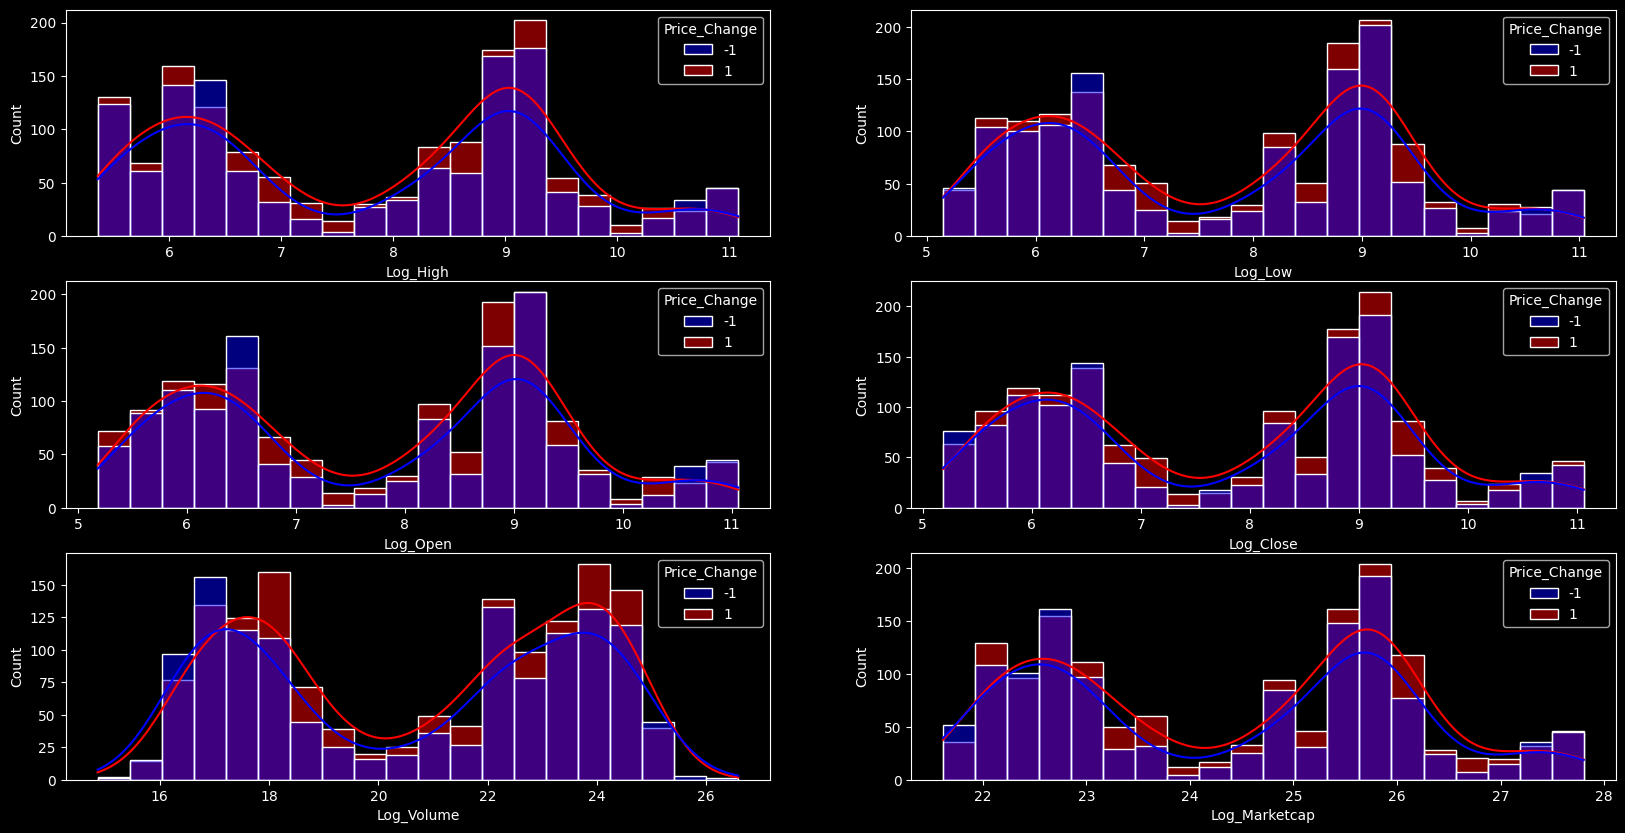

In [220]:
LOG_DF = DF.copy()

width = 2
height = int(np.ceil(len(log_num_columns)/width))
fig, ax = plt.subplots(nrows=height, ncols=width, figsize=(20,10)) # создаем "полотно", на котором будем "рисовать" графики
#     ↑  более точная структура (почти синоним subplot). Говорим что у нас будет height строк и width столбцов

for idx, log_column in enumerate(log_num_columns): # перебираем все числовые данные
    plt.subplot(height,width, idx+1) #берем конкретную ячейку из заранее подготовленную заготовки
    # рисуем с помощью библиотеки seaborn
    sns.histplot(data=LOG_DF, # какой датафрейм используем
                x=log_column, # какую переменную отрисовываем
                hue='Price_Change', # исп нашу категориальный признак
                kde=True, # отрисуй тренд
                palette='bwr', # цвет
                bins = 20);  # на сколько ячеек разбиваем

Уже на гистограмме видно, что после логарифмического преобразования данные сместились в центр и выглядят более размеренно

### Стандартизация

Первый шаг

In [206]:

scaler = StandardScaler()

# Стандартизация выбранных колонок
scaler.fit(LOG_DF[log_num_columns])

StandardScaler()

Шаг второй

In [207]:
scaled = scaler.transform(LOG_DF[log_num_columns])

df_standard = pd.DataFrame(scaled, columns=log_num_columns)
df_standard

,Log_High,Log_Low,Log_Open,Log_Close,Log_Volume,Log_Marketcap
0,-0.712461,-0.740524,-0.711394,-0.735262,-1.007468,-0.854832
1,-0.737179,-0.747758,-0.732299,-0.741398,-1.128746,-0.860421
2,-0.735897,-0.739792,-0.740700,-0.726902,-1.306577,-0.846644
3,-0.721204,-0.717723,-0.729473,-0.717752,-1.278240,-0.838041
4,-0.726082,-0.719465,-0.713804,-0.719492,-1.275218,-0.839677
...,...,...,...,...,...,...
2744,1.626228,1.642618,1.637096,1.641984,1.219510,1.628976
2745,1.643680,1.654518,1.642713,1.655953,1.066120,1.642114
2746,1.661665,1.672780,1.657416,1.666941,1.073387,1.652455
2747,1.650301,1.650982,1.668402,1.639211,1.096471,1.626444


### Проверка

Визуализируем

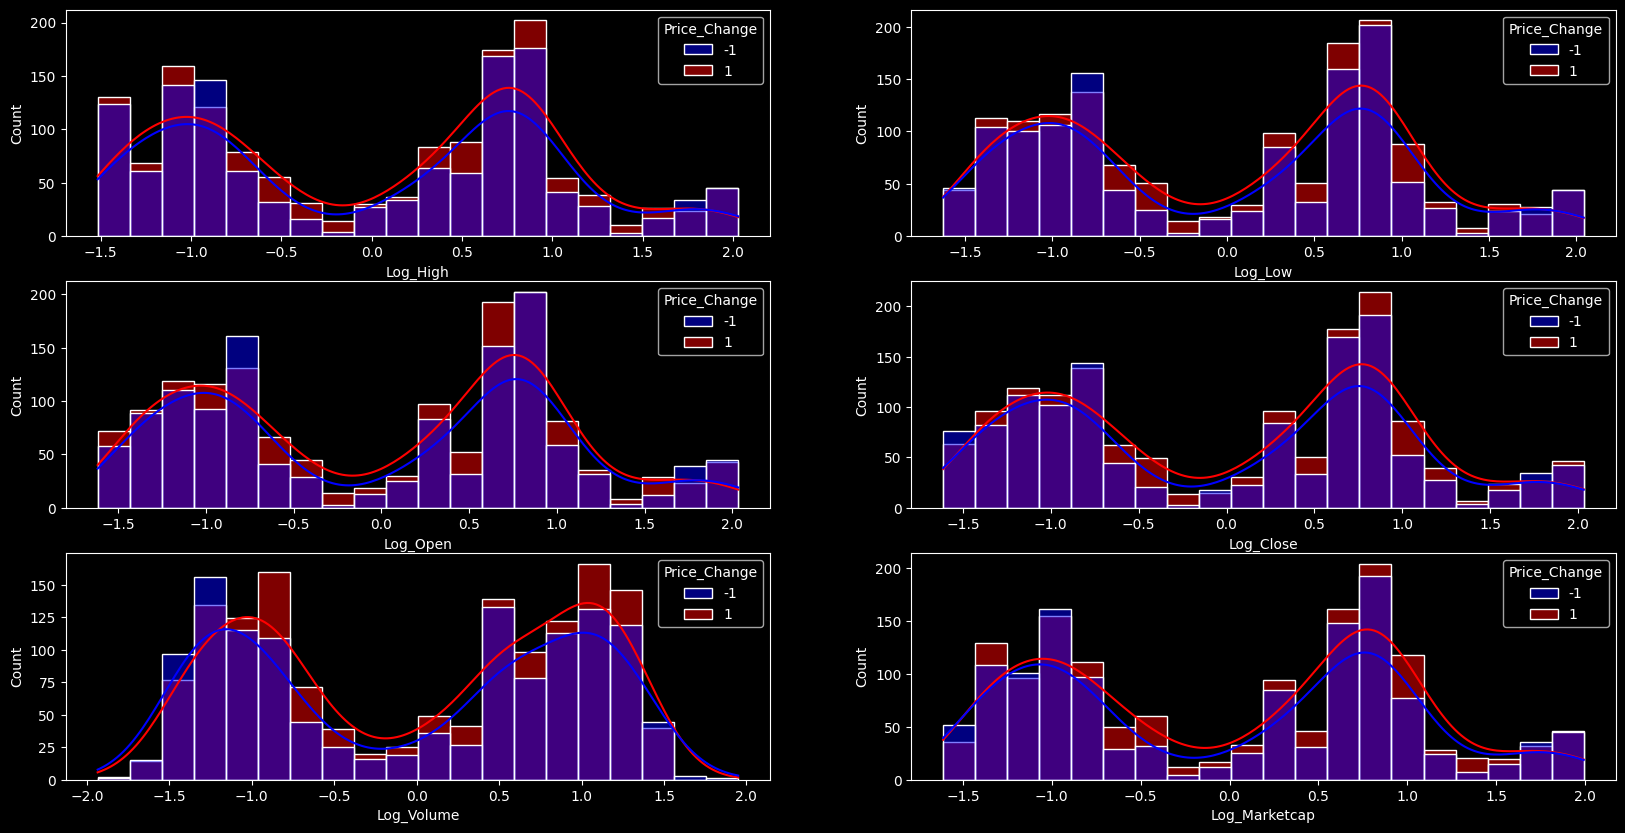

In [221]:
width = 2
height = int(np.ceil(len(log_num_columns)/width))
fig, ax = plt.subplots(nrows=height, ncols=width, figsize=(20,10)) # создаем "полотно", на котором будем "рисовать" графики
#     ↑  более точная структура (почти синоним subplot). Говорим что у нас будет height строк и width столбцов

for idx, log_column in enumerate(log_num_columns): # перебираем все числовые данные
    plt.subplot(height,width, idx+1) #берем конкретную ячейку из заранее подготовленную заготовки
    # рисуем с помощью библиотеки seaborn
    sns.histplot(data=df_standard, # какой датафрейм используем
                x=log_column, # какую переменную отрисовываем
                hue='Price_Change', # исп нашу категориальный признак
                kde=True, # отрисуй тренд
                palette='bwr', # цвет
                bins = 20);  # на сколько ячеек разбиваем

Масштаб действительно стал единообразным, проверим на остальных визуализациях

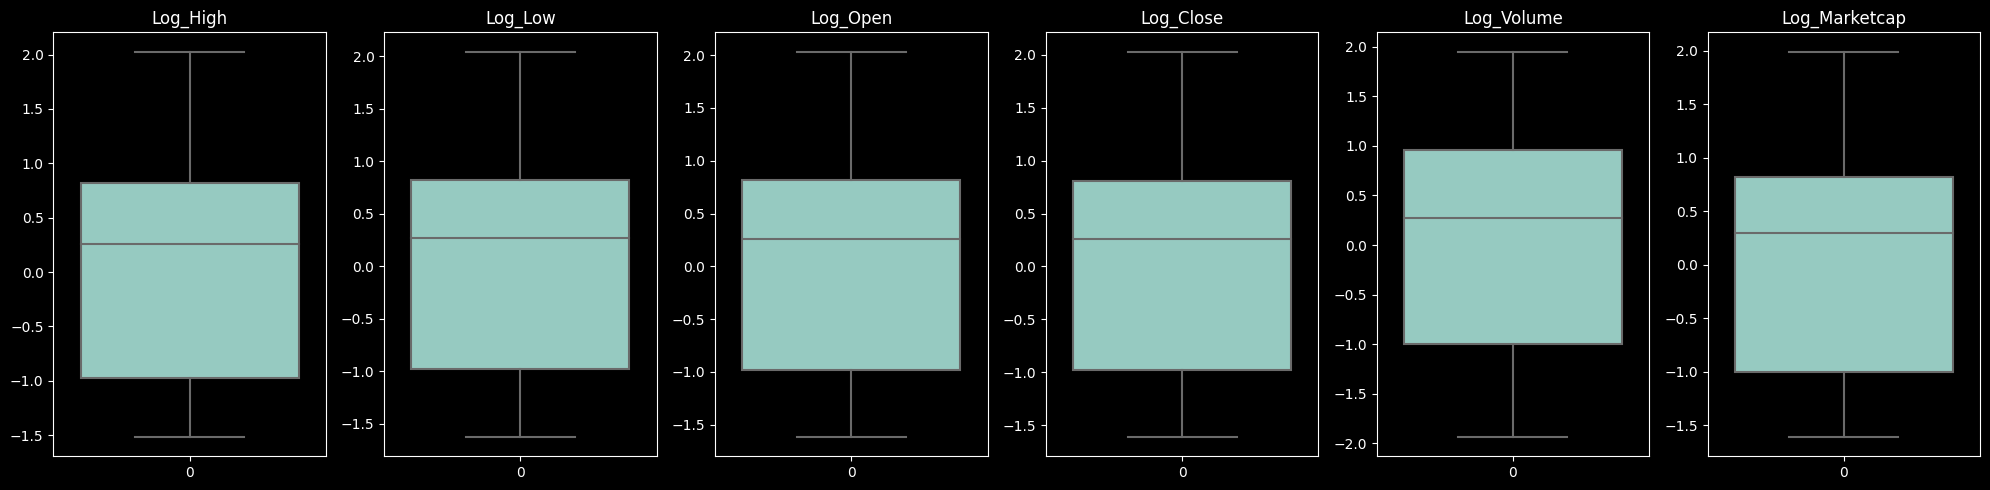

In [211]:
# Визуализация с помощью Boxplot для каждого признака
fig, axs = plt.subplots(1, 6, figsize=(20, 5))

i = 0
for log_colum in log_num_columns:
  sns.boxplot(data=df_standard[log_colum], ax=axs[i]).set_title(log_colum)
  i += 1

plt.tight_layout()
plt.show()

Почти идеально однако есть небольшое смещение вниз.

Перейдем к визуализации отношений на Pairplot

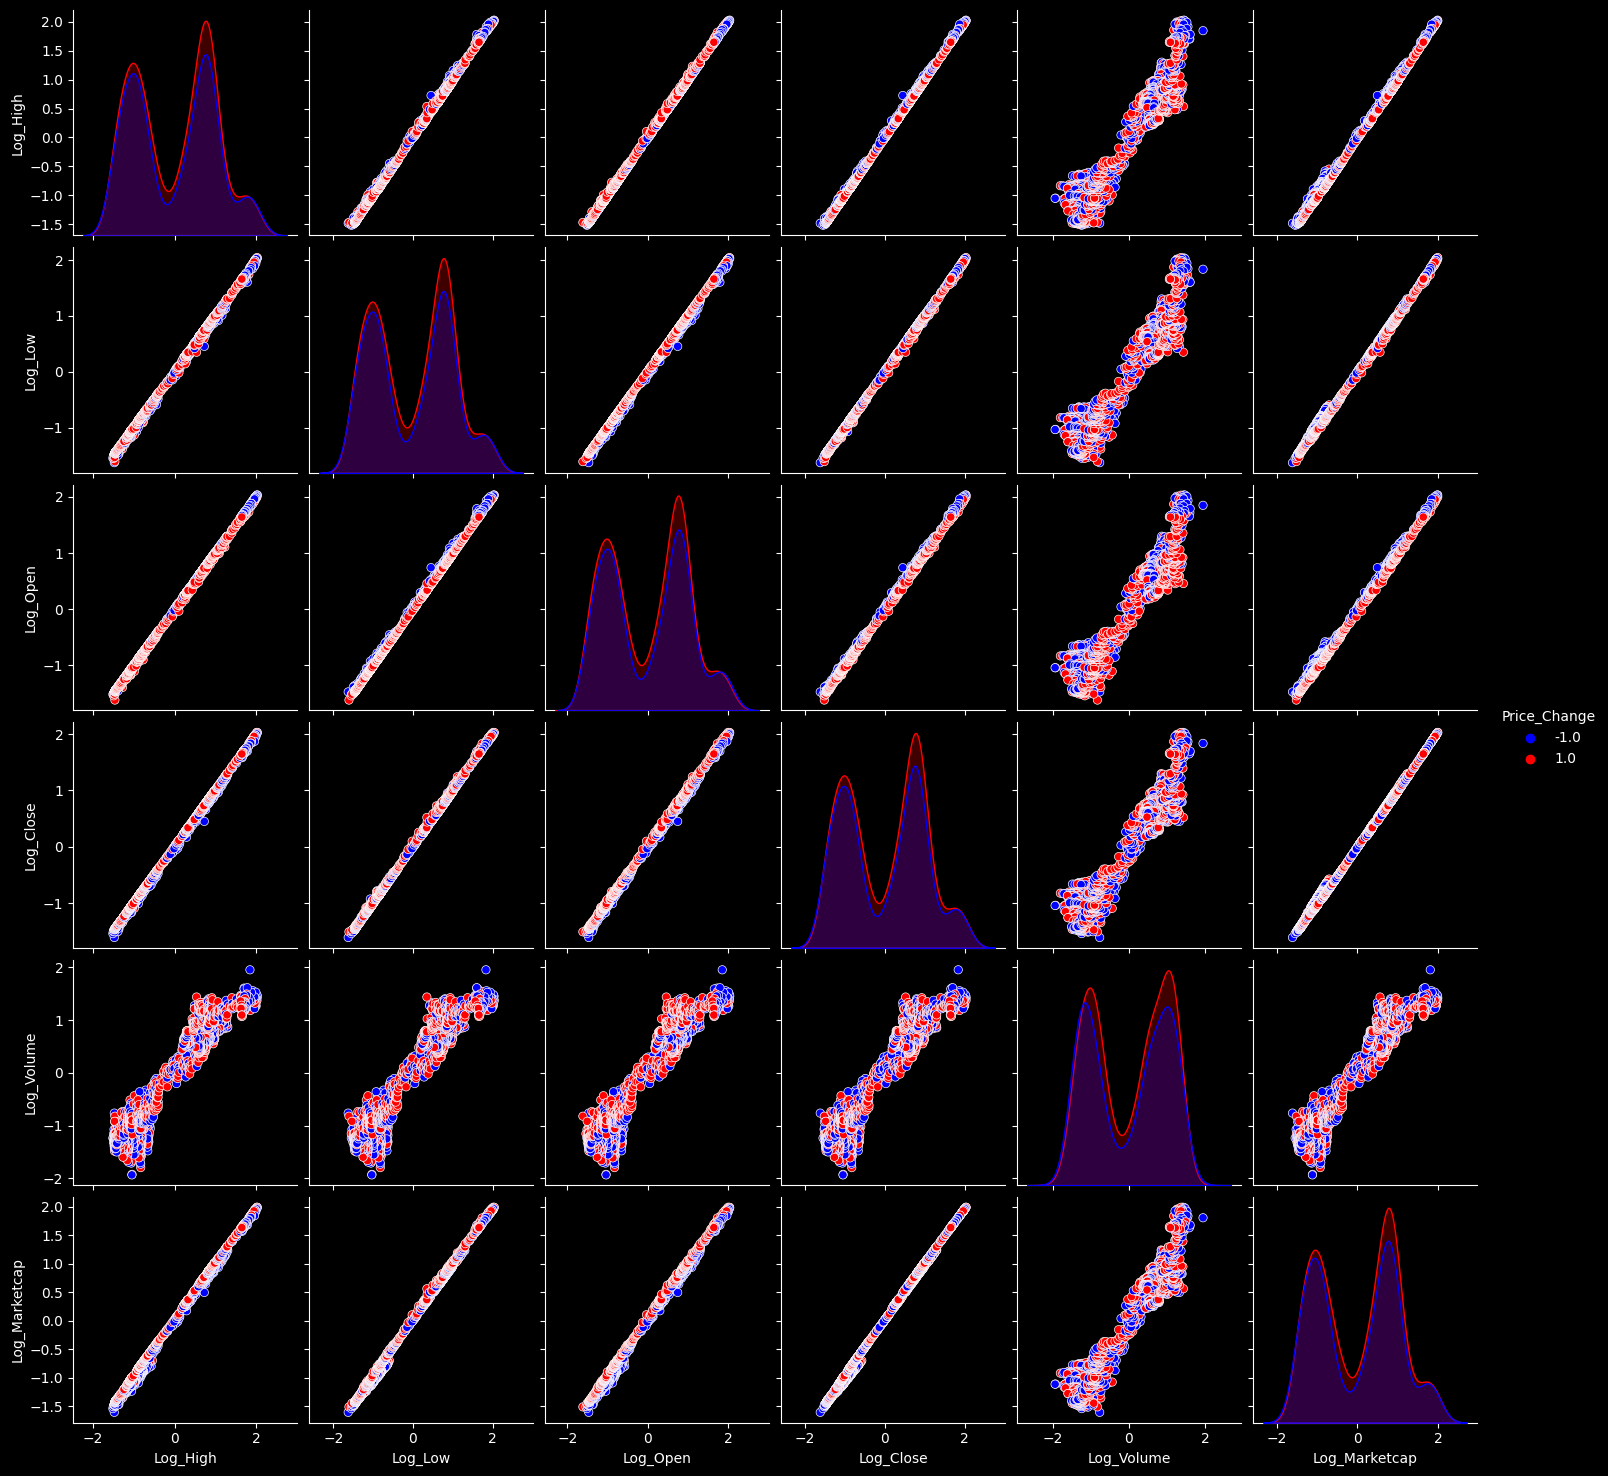

In [213]:
# Добавим дату и price change к стандартизированному дата фрейму
df_standard['Date'] = DF['Date']
df_standard['Price_Change'] = DF['Price_Change']

grouped = df_standard.groupby('Date').mean(log_num_columns) # обновим группировку по дате с новыми данными


# Создание Pairplot для выбранных признаков
sns.pairplot(data = grouped,
              hue ='Price_Change', # какую переменную используем для подкрашиваиния данных.
                                # Рекомендуется использовать Категориальные данные (не очень много уникальных значений)
              palette = 'bwr',); # какую цветовую карту используем. Здесь у нас всего 2 варианта, то мы используем bwr - один из Diverging
                                # если категорий больше, то лучше использовать что-то из Qualitative
plt.show()

Данные стали гораздо более читаемые и ясно прослеживается линейная зависимость между признаками

Построим график изменений цены

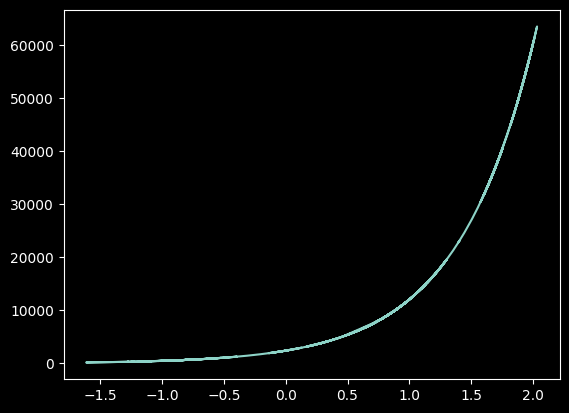

In [222]:
plt.plot(df_standard['Log_Close'], DF['Close'])